# 기본 회로 성질

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
from math import pi
qc = QuantumCircuit(2)
c = 0
t = 1

양자 컴퓨터를 프로그래밍할 때, 우리의 목표는 항상 기본적인 구성 요소에서 유용한 양자 회로를 구축하는 것입니다. 그러나 때로는 우리가 필요로 하는 모든 기본 구성 요소가 없을 수도 있습니다. 이 장에서는 기본 게이트 간에 서로를 변환하는 방법과 이를 사용하여 약간 더 복잡한 (그러나 여전히 매우 기본적인) 게이트를 만드는 방법을 살펴보겠습니다.

이 장에서 논의된 많은 기법들은 1995년 Barenco와 공동 저자의 논문에서 처음 제안되었습니다 [1].

## 목차

1. [CNOT 게이트로 제어-Z 게이트 만들기](#c-from-cnot)
2. [큐비트 교환하기](#swapping)
3. [제어 회전 게이트](#controlled-rotations)
4. [Toffoli 게이트](#ccx)
5. [H 게이트와 T 게이트를 이용하여 임의의 회전 만들기](#arbitrary-rotations)
6. [참고문헌](#references)

## 1. CNOT 게이트로 제어-Z 게이트 만들기 <a id="c-from-cnot"></a>

제어-Z 게이트라고도 불리는 `cz` 게이트는 자주 사용되는 이중 큐비트 게이트 중 하나입니다. 제어 큐비트가 $|1\rangle$ 상태일 때 CNOT 게이트가 목표 큐비트에 $X$ 게이트를 적용하는 것처럼, 제어-$Z$ 게이트는 같은 경우에 $Z$ 게이트를 적용합니다. Qiskit에서는 이를 다음과 같이 직접 불러올 수 있습니다.

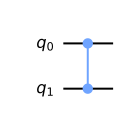

In [2]:
# a controlled-Z
qc.cz(c,t)
qc.draw()

이때 c와 t는 각각 제어 큐비트와 목표 큐비트입니다. 그러나 IBM Q 장치에서는 이중 큐비트 게이트 중 오직 CNOT 게이트만 직접적으로 적용될 수 있습니다. 그러므로 우리는 CNOT 게이트를 이용해 제어-Z 게이트를 만들 방법이 필요합니다.

이를 위한 방법은 꽤 간단합니다. 우리는 하다마드 게이트가 $|0\rangle$ 과 $|1\rangle$ 상태를 각각 $|+\rangle$ 와 $|-\rangle$ 상태로 변환시켜 주는 것을 알고 있습니다. 또한 $|+\rangle$ 와 $|-\rangle$에 대한 $Z$ 게이트의 효과가 $|0\rangle$ 와 $|1\rangle$에 대한 $X$ 게이트의 효과와 동일하다는 것도 알고 있습니다. 이런 이유로, 또는 간단한 행렬 곱으로부터, 우리는 다음과 같은 사실을 알 수 있습니다.

$$ H X H = Z,\ H Z H = X. $$

CNOT 게이트를 제어-$Z$ 게이트로 바꿀 때도 같은 방식이 적용될 수 있습니다. 우리가 해야할 일은 CNOT 게이트의 목표 큐비트 앞뒤에 하다마드 게이트를 적용하는 것입니다. 이를 통해 어떤 $X$ 게이트라도 $Z$ 게이트로 바꿀 수 있습니다.

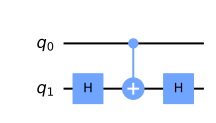

In [3]:
qc = QuantumCircuit(2)
# also a controlled-Z
qc.h(t)
qc.cx(c,t)
qc.h(t)
qc.draw()

더욱 일반적으로, 우리는 단순히 CNOT 게이트 앞뒤에 적절한 회전 게이트를 넣음으로써, 하나의 CNOT 게이트를 블로흐 구 위에서 $\pi$만큼 도는 임의의 제어 회전 게이트로 바꿀 수 있습니다. 예를 들어, 제어-$Y$ 게이트는 다음과 같이 바꿀 수 있습니다.

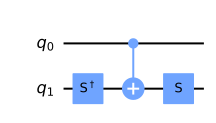

In [4]:
qc = QuantumCircuit(2)
# a controlled-Y
qc.sdg(t)
qc.cx(c,t)
qc.s(t)
qc.draw()

그리고 제어-$H$ 게이트는 다음과 같이 바꿀 수 있다.

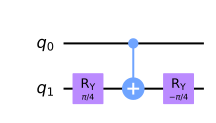

In [5]:
qc = QuantumCircuit(2)
# a controlled-H
qc.ry(pi/4,t)
qc.cx(c,t)
qc.ry(-pi/4,t)
qc.draw()

## 2. 큐비트 교환하기 <a id="swapping"></a>

In [6]:
a = 0
b = 1

때때로 우리는 양자 컴퓨터에서 주변의 정보를 이동시켜야 할 때가 있습니다. 특정 큐비트 구현 방식에서는, 물리적으로 큐비트를 움직여서 정보를 이동시킬 수 있습니다. 다른 선택지로는 단순히 두 큐비트 사이에서 상태가 옮겨 다니도록 하는 것입니다. 이는 SWAP 게이트를 통해 구현될 수 있습니다.

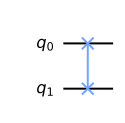

In [7]:
qc = QuantumCircuit(2)
# swaps states of qubits a and b
qc.swap(a,b)
qc.draw()

위의 명령은 SWAP 게이트를 바로 호출해내지만, 표준 게이트 집합을 사용해서 어떻게 SWAP 게이트를 만들 수 있는지 살펴보도록 합시다. 이를 위해서는 몇 가지 예시를 고려해야 합니다.

먼저 큐비트 a가 $|1\rangle$ 상태이고 큐비트 b가 $|0\rangle$ 상태인 경우를 살펴보겠습니다. 이를 위해서 다음과 같이 게이트를 적용할 수 있습니다.

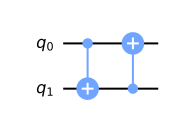

In [8]:
qc = QuantumCircuit(2)
# swap a 1 from a to b
qc.cx(a,b) # copies 1 from a to b
qc.cx(b,a) # uses the 1 on b to rotate the state of a to 0
qc.draw()

이는 큐비트 b를 $|1\rangle$ 상태로, 큐비트 a를 $|0\rangle$ 상태로 만드는 효과를 갖습니다. 적어도 이 상황에서는, SWAP을 해냈다고 말할 수 있겠습니다.

이제 이 상태를 다시 SWAP하여 원래의 상태로 돌려놓아 보겠습니다. 예상 하셨듯이, 위 과정에 있는 게이트의 순서를 반대로 하면 됩니다.

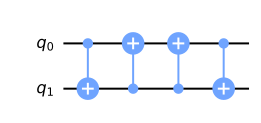

In [9]:
# swap a q from b to a
qc.cx(b,a) # copies 1 from b to a
qc.cx(a,b) # uses the 1 on a to rotate the state of b to 0
qc.draw()

앞선 두 가지 과정 중에서, 한 과정에 있는 첫 번째 게이트는 나머지 과정에 있는 초기 큐비트 상태에 영향을 주지 않을 것임에 주목하십시오. 예를 들어, 우리가 $|1\rangle$을 b에서 a로 보내려 할 때에, 첫 번째 게이트는 `cx(b,a)`입니다. 만약 b에 $|1\rangle$가 초기에 적용되지 않았던 상태에서 해당 게이트가 적용된다면, 이 게이트는 아무런 효과도 없을 것입니다.

또한 이들 두 과정 중에서, 각 과정에 있는 마지막 게이트는 다른 과정에 있는 최종 큐비트 상태에 영향을 주지 않을 것임에도 주목하십시오. 예를 들어, $|1\rangle$ 상태를 a에서 b로 보내려 할 때 요구되는 마지막 게이트 `cx(b,a)`는 $|1\rangle$이 b에 있는 상태가 아니라면 아무런 효과가 없습니다.

이러한 관찰로, 우리는 영향을 주지 않는 게이트를 나머지 과정에 추가하는 것으로 앞선 두 개의 과정을 결합할 수 있습니다. 예를 들어,

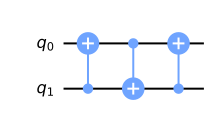

In [10]:
qc = QuantumCircuit(2)
qc.cx(b,a)
qc.cx(a,b)
qc.cx(b,a)
qc.draw()

우리는 이 코드를 a에서 b로 $|1\rangle$를 이동시키지만, 맨 앞에 쓸모 없는 `qc.cx(b,a)`가 존재하는 과정으로 생각할 수 있습니다. 또한 $|1\rangle$를 b에서 a로 이동시키지만, 맨 마지막에 쓸데 없는 `qc.cx(b,a)`가 있는 과정으로도 생각할 수 있습니다. 어느 쪽이든, 결과적으로 이 코드는 양방향으로 상태를 교환할 수 있는 코드입니다.

이는 $|00\rangle$ 상태에도 정확히 적용됩니다. 해당 상태는 대칭적이고, 따라서 상태를 서로 교환하는 것은 아무런 효과가 없을 것입니다. CNOT 게이트는 제어 큐비트가 $|0\rangle$ 상태일 때 아무 효과가 없기 때문에, 이 코드는 정확히 아무것도 하지 않을 것입니다.

$|11\rangle$ 상태 또한 대칭적이기 때문에, 상태 교환에 있어 미미한 영향만 있어야 합니다. 이 경우, 첫 번째 CNOT 게이트는 두 번째 CNOT 게이트에 영향을 주지 않고, 세 번째 CNOT 게이트는 첫 번째 CNOT 게이트를 실행취소합니다. 그러므로, 전체적인 효과는 실로 미미합니다.

그러므로, 우리는 SWAP 게이트를 단일 큐비트 회전과 CNOT 게이트의 표준 게이트 집합으로 분해하는 방법을 찾아냈습니다.

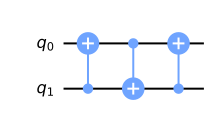

In [11]:
qc = QuantumCircuit(2)
# swaps states of qubits a and b
qc.cx(b,a)
qc.cx(a,b)
qc.cx(b,a)
qc.draw()

이 분해 결과는 $|00\rangle$, $|01\rangle$, $|10\rangle$, 그리고 $|11\rangle$ 상태에 대해서 작동하며, 만약 이 분해 결과가 모든 계산 기반 상태에 대해서 작동 한다면, 모든 상태에 대해서도 분명 일반적으로 작동할 것입니다. 그러므로 이 회로는 모든 이중 큐비트 상태를 교환할 수 있습니다.

CNOT 게이트의 순서를 바꿔도 동일한 효과가 도출될 것입니다:

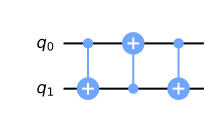

In [12]:
qc = QuantumCircuit(2)
# swaps states of qubits a and b
qc.cx(a,b)
qc.cx(b,a)
qc.cx(a,b)
qc.draw()

이는 SWAP 게이트를 얻는 동등하게 유효한 방법입니다.

여기서 사용된 유도법은 상당 부분 z 기반 상태를 바탕으로 두었지만, $|+\rangle$ 상태와 $|-\rangle$ 상태를 교환하는데 무엇이 필요한지를 생각함으로써 수행될 수도 있습니다. 결과적으로 SWAP 게이트를 구현하는 방법은 위의 방식과 완전히 동등하게 될 것입니다.

#### 막간 연습:

- $|+\rangle$ 상태와 $|-\rangle$ 상태를 가진 큐비트 간에 상태를 교환하는 다른 회로를 찾고, 이 회로가 위의 회로와 동일함을 보이시오.

## 3. 제어 회전 게이트 <a id="controlled-rotations"></a>

우리는 이미 제어 $\pi$ 회전을 어떻게 단일 CNOT 게이트로부터 만드는지 보았습니다. 이제 우리는 임의의 제어 회전을 어떻게 만드는지 살펴볼 것입니다.

먼저, y축을 중심으로 임의의 회전을 하는 경우를 생각해봅시다. 구체적으로는, 아래와 같은 게이트의 나열을 생각해보십시오.

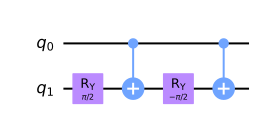

In [13]:
qc = QuantumCircuit(2)
theta = pi # theta can be anything (pi chosen arbitrarily)
qc.ry(theta/2,t)
qc.cx(c,t)
qc.ry(-theta/2,t)
qc.cx(c,t)
qc.draw()

만약 제어 큐비트가 $|0\rangle$ 상태라면, 이 코드는 단지 $R_y(\theta/2)$ 게이트를 적용한 후 바로 이 게이트의 역인 $R_y(-\theta/2)$ 게이트를 걸어주는 것이 될 것입니다. 이 영향은 아주 사소합니다. 그러나 만약 제어 큐비트가 $|1\rangle$ 상태라면, `ry(-theta/2)` 게이트가 X 게이트 앞뒤에 적용이 됩니다. 이는 방향을 뒤집은 후 두 번째 $R_y(\theta/2)$ 게이트를 걸어주는 효과를 가집니다. 따라서 이 경우 순 효과는 <br> $R_y(\theta)$ 게이트의 제어 버전을 만드는 것입니다.

이 방법은 x축과 y축이 서로 직교하여 X 게이트가 회전의 방향을 뒤집기 때문에 동작합니다. 그러므로 비슷한 방식이 제어-$R_z(\theta)$ 게이트에도 적용될 수 있습니다. 제어-$R_x(\theta)$ 게이트는 CNOT 게이트를 이용해 유사하게 만들 수 있습니다.

또한 같은 방식으로 임의의 단일 제어 회전 게이트 $V$를 만들 수 있습니다. 이를 위해서는 다음과 같이 A, B, C 세개의 회전과 위상  $\alpha$를 찾으면 됩니다.

$$ ABC = I, ~~~e^{i\alpha}AZBZC = V $$

그러면 우리는 제어-Z 게이트를 사용하여 제어 큐비트가 $|0\rangle$ 상태일 때는 첫 번째 식대로, 제어 큐비트가 $|1\rangle$ 상태일 때 두 번째 식대로 회로가 작동하도록 만듭니다. $R_z(2\alpha)$ 회전은 올바른 위상을 얻는 데 사용되며, 중첩 상태가 있을 때마다 중요하게 작용합니다.

In [14]:
A = Gate('A', 1, [])
B = Gate('B', 1, [])
C = Gate('C', 1, [])
alpha = 1 # arbitrarily define alpha to allow drawing of circuit

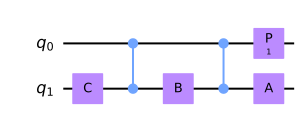

In [15]:
qc = QuantumCircuit(2)
qc.append(C, [t])
qc.cz(c,t)
qc.append(B, [t])
qc.cz(c,t)
qc.append(A, [t])
qc.p(alpha,c)
qc.draw()

![A controlled version of a gate V](images/iden1.png)

`A`, `B` 그리고 `C`는 각각 $A$ , $B$ 그리고 $C$ 게이트를 의미합니다.

## 4. Toffoli 게이트<a id="ccx"></a>

Toffoli 게이트는 두 개의 제어 큐비트와 하나의 목표 큐비트를 가진 삼중 큐비트 게이트입니다. 이 게이트는 두 제어 큐비트가 모두 $|1\rangle$일 때 목표 큐비트에 X 게이트를 작동시킵니다. 목표 큐비트의 마지막 상태는 목표 큐비트의 초기 상태가 $|0\rangle$인지 $|1\rangle$인지에 따라 두 제어 큐비트의 AND 또는 NAND와 같습니다. Toffoli 게이트는 또한 제어-제어-NOT 게이트로도 생각할 수 있기에 CCX 게이트라고도 불립니다.

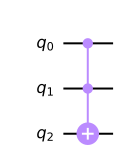

In [16]:
qc = QuantumCircuit(3)
a = 0
b = 1
t = 2
# Toffoli with control qubits a and b and target t
qc.ccx(a,b,t)
qc.draw()

단일 게이트와 이중 게이트를 어떻게 만드는지 보려면, 먼저 가장 일반적인 경우인 임의의 단일 큐비트 회전 게이트 U에 대한 제어-제어-U 게이트를 어떻게 만드는지 보는 것이 도움이 될 것입니다. 이를 위해 우리는 $V = \sqrt{U}$와 $V^\dagger$의 제어 버전을 정의해보겠습니다. 아래 코드에서는 우리는 정의되지 않은 `cv`와 `cvdg` 대신 `cp(theta,c,t)`와 `cp(-theta,c,t)`를 사용했습니다. 제어 큐비트는 $a$와 $b$이고, 목표 큐비트는 $t$입니다.

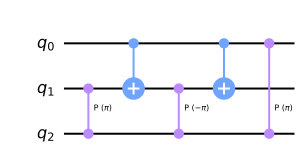

In [17]:
qc = QuantumCircuit(3)
qc.cp(theta,b,t)
qc.cx(a,b)
qc.cp(-theta,b,t)
qc.cx(a,b)
qc.cp(theta,a,t)
qc.draw()

![A doubly controlled version of a gate V](images/iden2.png)

제어 큐비트 각각의 값들을 따라가봄으로써, U 게이트가 오직 제어 큐비트 두 개 모두 1인 경우에만 작동한다는 것을 알 수 있습니다. 앞에서 설명한 아이디어를 사용하여, 이제 각각의 제어-V 게이트를 구현하여 이중-제어-U 게이트 회로의 일부에 도달할 수 있습니다. Toffoli 게이트를 구현하는데 필요한 CNOT 게이트의 최소 개수는 6개로 알려져있습니다[2].

![A Toffoli](images/iden3.png)

위 그림은 3 큐비트(q0, q1, q2)에 대한 Toffoli 게이트이다. 이 예시에서 q0는 q2와 연결되어 있지만, q0는 q1과는 연결되어 있지 않습니다.

양자 컴퓨팅에서 Toffoli 게이트가 AND 게이트를 구현하는 유일한 방법은 아닙니다. 같은 효과를 갖는 다른 게이트를 정의하는 것도 가능합니다. 그러나 상대 위상이라는 개념을 가져와야 합니다. 이 경우, 우리는 조금의 CNOT 게이트들로 구현할 수 있습니다.

예를 들어, 제어-하다마드 게이트와 제어-$Z$ 게이트를 같이 사용하는 경우를 가정해봅시다. 둘 모두 하나의 CNOT 게이트로 구현됩니다. 이때 우리는 다음과 같이 회로를 구성할 수 있습니다.

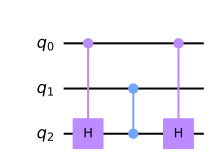

In [18]:
qc = QuantumCircuit(3)
qc.ch(a,t)
qc.cz(b,t)
qc.ch(a,t)
qc.draw()

두 제어 큐비트가 $|00\rangle$일 때, 이 코드는 목표 큐비트에 어떠한 영향도 주지 않습니다. $|11\rangle$의 경우에는, 목표 큐비트에 하다마드-$Z$-하다마드 순으로 게이트가 작용합니다. 순 효과는 목표 큐비트에 $X$가 작용한 것입니다. $|01\rangle$와 $|10\rangle$ 상태에는 목표 큐비트에 (서로 맞물려서 취소되는 )두 개의 하다마드 게이트가 작용하게 되거나 (상대 위상을 유도하는) $Z$ 게이트가 작용하게 됩니다. 그러므로 이 코드는 제어 큐비트들의 상태가 $|11\rangle$일때만 목표 큐비트의 값이 바뀌므로 AND의 효과를 내면서, 세 개의 CNOT으로 효과를 냈다고 볼 수 있습니다.

## 5. H 게이트와 T 게이트를 이용하여 임의의 회전 만들기<a id="arbitrary-rotations"></a>

현재의 장치에 있는 큐비트에는 기본적으로 실수로 작용되는 게이트로 만들어진 노이즈가 발생합니다. 온도, 자기장 또는 이웃한 큐비트의 움직임 같은 단순한 것들이 우리가 의도하지 않은 현상을 만들 수 있습니다.

양자컴퓨터를 대규모로 응용하기 위해서는, 큐비트를 노이즈로부터 보호하는 방식으로 우리의 큐비트를 암호화하는 것이 필수적일 것입니다. 이는 게이트가 실수로 작용하거나, 약간 잘못된 방식으로 구현되는 것을 어렵게 만듦으로써 수행할 수 있습니다.

게이트가 의도치 않게 작동하는 것은 단일 큐비트 회전 $R_x(\theta)$, $R_y(\theta)$ 그리고 $R_z(\theta)$에게는 유감스러운 일입니다. <br> 우리가 뜻하지 않게 $\theta + 0.0000001$ 같은 것을 구현하지 않는다고 확신할 수 있을 만큼, $\theta$를 완벽한 정확도로 구현하는 것은 불가능합니다. 우리가 달성할 수 있는 정확도에는 항상 한계가 있고, 이는 거대한 회로에 걸쳐서 결함이 쌓이는 것을 우리가 설명할 때 감안할 수 있는 것보다 항상 더 클 것입니다. 그러므로 우리는 결함-허용 양자 컴퓨터에서 이들 회전을 직접 구현할 수 없지만, 대신 더욱 신중한 방식으로 이들을 구현할 필요가 있습니다.

결함-허용 체계에서 이러한 회전들을 $H$와 $T$를 사용하여 구현할 수 있습니다.

Qiskit에서는 T 게이트를 `.t()`로 표현합니다.

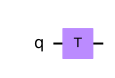

In [19]:
qc = QuantumCircuit(1)
qc.t(0) # T gate on qubit 0
qc.draw()

이는 Z축을 기반으로 $\theta = \pi/4$만큼 돌리는 회전 게이트입니다. 수학적으로는 $R_z(\pi/4) = e^{i\pi/8~Z}$로 표현됩니다.

다음에서는 $H$ 와 $T$ 게이트가 효과적으로 완벽하다고 가정합니다. 이는 오류 수정 및 오류허용을 위한 적절한 방법으로 설계를 가능하게 합니다.

하다마드 게이트와 바로 위 챕터에서 설명한 방법을 사용하여, T 게이트를 사용해 x축으로 유사한 회전을 만들 수 있습니다.

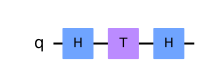

In [20]:
qc = QuantumCircuit(1)
qc.h(0)
qc.t(0)
qc.h(0)
qc.draw()

이제 둘을 같이 놓아봅시다. $R_z(\pi/4)~R_x(\pi/4)$ 게이트를 만들어보도록 합시다.

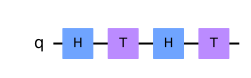

In [21]:
qc = QuantumCircuit(1)
qc.h(0)
qc.t(0)
qc.h(0)
qc.t(0)
qc.draw()

이것은 단일 큐비트 게이트이기 때문에, 블로흐 구를 중심으로 회전한다고 생각할 수 있습니다. 이는 임의의 각도로 임의의 축을 회전함을 의미합니다. 축에 대해서 너무 깊게 생각할 필요는 없지만, 분명히 x축, y축이나 z축은 아닐 것입니다. 더 중요한 것은 각도입니다.

이 회전 각도의 중요한 특성은 이 각도가 $\pi$의 무리수 배수라는 것입니다. 여러분 스스로 이것을 여러 수학을 사용해서 증명할 수 있지만, 게이트를 적용함으로써도 무리수 성질이 있는 것을 확인할 수 있을 것입니다. $2\pi$보다 큰 각도로 회전시킬 때마다, 그 회전 각도에 암시적인 $2\pi$에 대한 나머지 연산을 한다는 것을 생각해야 합니다. 그러므로, 위에서 언급한 결합된 회전 연산을 $n$번 반복하는 것은 동일한 축을 중심으로 하는 다른 각도에 대한 회전을 만듭니다. 엄밀한 증명을 위해서 힌트를 주자면, 무리수는 어떤 방식으로 기술 될 수 없는지 기억해보세요.

이는 유용하게 사용할 수 있습니다. 각각의 각도는 $0$과 $2\pi$ 사이입니다. 이를 $n$ 조각을 내어 $2\pi/n$ 간격으로 만들어보겠습니다. 각각의 반복에 대해, 결과로 나오는 각도는 이 조각 중 하나입니다. 처음 $n+1$ 반복의 각도를 보면, 비둘기집 원리 때문에 적어도 하나의 조각에 이런 각도 중 두 개가 포함되게 됩니다. $n_1$을 사용하여 첫 번째에 필요한 반복 횟수를 나타내고, $n_2$를 사용하여 두 번째를 나타내봅시다.

이를 통해, 우리는 $n_2-n_1$ 반복에서의 각도에 대해 어떤 것을 증명할 수 있습니다. 이는 $n_2$ 반복을 한 다음 $n_1$ 반복의 역을 한 것과 사실상 같습니다. 이들 각도는 동일하지는 않지만(무리수 성질 때문에) $2\pi/n$보다 크지는 않기에(동일한 조각에 있기 때문에) $n_2-n_1$ 반복에 대한 각도는 다음 식을 만족합니다.

$$ \theta_{n_2-n_1} \neq 0, ~~~~-\frac{2\pi}{n} \leq \theta_{n_2-n_1} \leq \frac{2\pi}{n} . $$

따라서 우리는 작은 각도로 회전시킬 수 있습니다. 이 게이트를 여러 번 반복함으로써 원하는 만큼의 작은 각도로 회전시킬 수 있습니다.

그리고 작은 각도 회전을 사용함으로써 원하는 어떤 각도로도 회전시킬 수 있습니다. 항상 정확하지는 않지만, $2\pi/n$까지는 정확함을 보장합니다. 이 값은 원하는 만큼 작게 만들 수 있습니다. 이제 회전의 부정확성에 대해 어느 정도 대응을 할 수 있게 되었습니다.

지금까지는 한 축을 중심으로만 이런 임의의 회전을 할 수 있었습니다.  두 번째 축의 경우, 간단하게  $R_z(\pi/4)$와 $R_x(\pi/4)$ 회전을 역 순서로 적용합니다.

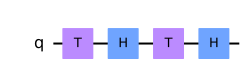

In [22]:
qc = QuantumCircuit(1)
qc.t(0)
qc.h(0)
qc.t(0)
qc.h(0)
qc.draw()

이번 회전에서 고려한 축은 이전에 고려한 게이트의 축과 동일하지 않습니다. 그러므로 우리는 블로흐 구에서의 임의의 회전을 만드는 데 쓸 수 있는 두 개의 축에 대해 임의의 회전을 만들 수 있습니다. $T$ 게이트의 비용이 많이 들긴 하지만, 우리는 이제 모든 것을 할 수 있게 되었습니다.

양자 컴퓨팅에서 $T$ 게이트가 중요한 이유는 이런 식의 응용이 가능하기 때문입니다. 사실, 결함-허용 컴퓨터를 위한 알고리즘의 복잡성은 종종 $T$ 게이트가 얼마나 있는지와 관련하여 인용됩니다. 이는 최대한 적은 $T$ 게이트로 목표를 달성하려는 연구에 동기를 부여합니다. 위 논의는 단순히 $T$ 게이트가 이런 방식으로 사용될 수 있음을 증명하기 위한 것이고, 가장 효율적인 방식을 의미하지는 않습니다.

## 6. 참고문헌 <a id="references"></a>

[1] [Barenco, *et al.* 1995](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.52.3457?cm_mc_uid=43781767191014577577895&cm_mc_sid_50200000=1460741020)

[2] [Shende and Markov, 2009](http://dl.acm.org/citation.cfm?id=2011799)

In [23]:
import qiskit.tools.jupyter
%qiskit_version_table

/home/divs/anaconda3/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


Qiskit Software,Version
qiskit-terra,0.18.1
qiskit-aer,0.8.2
qiskit-ignis,0.6.0
qiskit-ibmq-provider,0.16.0
qiskit-aqua,0.9.4
qiskit,0.29.0
qiskit-nature,0.1.5
qiskit-finance,0.2.0
qiskit-optimization,0.2.1
qiskit-machine-learning,0.2.0
